<p style="text-align:center">
    <a href="https://skills.network" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo"  />
    </a>
</p>


# **Pre-Training and Fine-Tuning with PyTorch**

Estimated time needed: **60** minutes

As a machine learning engineer working for a streaming site, your objective is to develop a recommender system based on written movie reviews. Given that the dataset for these reviews is relatively small, your strategy leverages a larger, accessible dataset of magazine articles. The plan is to pretrain the model on this expansive magazine dataset to capture a broad understanding of text and language patterns. Subsequently, the model will undergo fine-tuning on the smaller, specific dataset of movie reviews to adapt its learned features to the particular task of recommending movies.



![Documents Overload](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IMDvs-jpgkFICi5fhx6Fr7LBPie55jA.jpg)

Fine-tuning a pretrained model can be approached in several ways, each with its advantages and disadvantages:

1. **Training the model on the small movie dataset:**
   - **Advantages:** Directly training on the movie review data ensures that the model is highly specialized and tailored to the specific characteristics and nuances of the dataset.
   - **Disadvantages:** Due to the small size of the dataset, the model is at a higher risk of overfitting. There might not be enough data to effectively capture all of the complexities of language and sentiment in movie reviews.

2. **Pretraining the model on a larger general-domain text and fine-tuning the movie dataset for each parameter:**
   - **Advantages:** This approach allows every part of the model to learn from the movie reviews, potentially improving its accuracy on the specific task.
   - **Disadvantages:** Fine-tuning all parameters with a small dataset can still lead to overfitting. It also requires huge computational resources and time, as adjustments across all parameters might lead to numerous iterations of training.

3. **Fine-tuning on the final layer only:**
   - **Advantages:** Fine-tuning only the final layer reduces the risk of overfitting, as the bulk of the model retains its pretrained structure. This method is faster and less resource-intensive.
   - **Disadvantages:** Because only the final layer is adjusted, the model might not fully adapt to the specifics of the movie reviews, potentially limiting its effectiveness in understanding deeper contextual nuances.

Each method offers a balance between adapting to the specifics of the movie review dataset and maintaining the robustness and generalizability learned from the larger magazine article dataset. Choosing the right strategy depends on the specific requirements and constraints of the project, such as available computational resources, the urgency of deployment, and the desired accuracy and specificity of the recommender system.


# __Table of contents__

<ol>
    <li><a href="#Objectives">Objectives</a></li>
    <li>
        <a href="#Setup">Setup</a>
        <ol>
            <li><a href="#Install-required-libraries">Install required libraries</a></li>
            <li><a href="#Import-required-libraries">Import required libraries</a></li>
            <li><a href="#Define-helper-functions">Defining helper functions</a></li>
        </ol>
    </li>
    <li><a href="#Positional-encodings">Positional encodings</a></li>
    <li><a href="#Import-IMDB-dataset">Import IMDB dataset</a></li>
    <ol>
        <li><a href="#IMDB-dataset-overview">IMDB dataset overview</a></li>
        <ol>
            <li><a href="#Dataset-composition">Dataset composition</a></li>
            <li><a href="#Applications">Applications</a></li>
            <li><a href="#Challenges">Challenges</a></li>
            <li><a href="#Dataset-splits">Dataset splits</a></li>
            <li><a href="#Data-loader">Data loader</a></li>
            <li><a href="#Neural-network">Neural network</a></li>
        </ol>
    </ol>
    <li>
        <a href="#Training">Training</a>
        <ol>
            <li><a href="#Train-IMDB">Train IMDB</a></li>
            <li><a href="#Fine-tune-a-model-pretrained-on-the-AG-News-dataset">Fine-tune a model pretrained on the AG News dataset</a></li>
            <li><a href="#Fine-tune-the-final-layer-only">Fine-tune the final layer only</a></li>
        </ol>
    </li>
    <li><a href="#Exercise:-Unfreeze-specific-layers-for-fine-tuning">Exercise: Unfreeze specific layers for fine-tuning</a></li>


---


# Objectives

After completing this lab, you will be able to:

- Define and pretrain a transformer-based neural network using PyTorch for a classification task
- Fully fine-tune the pretrained model for a different classification task
- Compare results by fine-tuning only the last layer of the pretrained model


---


# Setup


### Install required libraries


For this lab, you'll use the following libraries, which are __not__ preinstalled in the Skills Network Labs environment. __You must run the code in the following cell__ to install them.


In [7]:
#!pip install --upgrade portalocker==2.8.2 torchtext==0.17.0 torchdata==0.7.1 pandas==2.2.2 matplotlib==3.9.0 scikit-learn==1.5.0 torch==2.2.0 numpy==1.23.2

In [8]:
!pip install torch==2.2.2
!pip install torchtext==0.17.2
!pip install portalocker==2.8.2
!pip install torchdata==0.7.1
!pip install pandas
!pip install matplotlib==3.9.0 scikit-learn==1.5.0

In [9]:
!pip install numpy==1.26.0

### Import required libraries

The following imports the required libraries.


In [10]:
from tqdm import tqdm
import time
import numpy as np
import pandas as pd
from itertools import accumulate
import matplotlib.pyplot as plt
import math

import torch
torch.set_num_threads(1)
from torch import nn
import os


from torch.utils.data import DataLoader

from torchtext.datasets import AG_NEWS
from IPython.display import Markdown as md

from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator, GloVe, Vectors
from torchtext.datasets import IMDB
from torch.utils.data import Dataset
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset

import pickle

from urllib.request import urlopen
import io

import tarfile
import tempfile

from torch.nn.utils.rnn import pad_sequence

# You can also use this section to suppress warnings generated by your code:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

### Define helper functions

The following are some helper functions to help with plotting, saving, and loading files. These functions are not the main focus of this lab, so you do not have to dwell on these too long. However, do run the cells in this section to define these helper functions.


In [11]:
def plot(COST,ACC):

    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.plot(COST, color=color)
    ax1.set_xlabel('epoch', color=color)
    ax1.set_ylabel('total loss', color=color)
    ax1.tick_params(axis='y', color=color)

    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('accuracy', color=color)  # you already handled the x-label with ax1
    ax2.plot(ACC, color=color)
    ax2.tick_params(axis='y', color=color)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped

    plt.show()

In [12]:
def save_list_to_file(lst, filename):
    """
    Save a list to a file using pickle serialization.

    Parameters:
        lst (list): The list to be saved.
        filename (str): The name of the file to save the list to.

    Returns:
        None
    """
    with open(filename, 'wb') as file:
        pickle.dump(lst, file)

def load_list_from_file(filename):
    """
    Load a list from a file using pickle deserialization.

    Parameters:
        filename (str): The name of the file to load the list from.

    Returns:
        list: The loaded list.
    """
    with open(filename, 'rb') as file:
        loaded_list = pickle.load(file)
    return loaded_list

---


# Positional encodings

Positional encodings play a pivotal role in transformers and various sequence-to-sequence models, aiding in conveying critical information regarding the positions or sequencing of elements within a given sequence. To illustrate, let's examine the sentences: "He painted the car red" and "He painted the red car." Despite their distinct meanings, it's worth noting that the embeddings for these sentences remain identical in the absence of positional encodings. The following class defines positional encodings by inheriting from PyTorch's `Module` class.


In [13]:
class PositionalEncoding(nn.Module):
    """
    https://pytorch.org/tutorials/beginner/transformer_tutorial.html
    """

    def __init__(self, d_model, vocab_size=5000, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(vocab_size, d_model)
        position = torch.arange(0, vocab_size, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float()
            * (-math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[:, : x.size(1), :]
        return self.dropout(x)

# Import IMDB dataset


The following code loads the IMDB dataset.


In [14]:
urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/35t-FeC-2uN1ozOwPs7wFg.gz')
tar = tarfile.open(fileobj=io.BytesIO(urlopened.read()))
tempdir = tempfile.TemporaryDirectory()
tar.extractall(tempdir.name)
tar.close()

## IMDB dataset overview

The **IMDB dataset** contains movie reviews from the Internet Movie Database (IMDB) and is commonly used for binary sentiment classification tasks. It's a popular dataset for training and testing models in natural language processing (NLP), particularly in the context of sentiment analysis.

### Dataset composition

- **Reviews**: The dataset consists of 50,000 movie reviews, divided evenly into 25,000 training and 25,000 testing samples.
- **Sentiment labels**: Each review is labeled as either positive or negative, indicating the sentiment expressed in the review. The dataset is balanced, with an equal number of positive and negative reviews in both the training and testing sets.
- **Text content**: Reviews are presented as plain text and have been preprocessed to some extent. For example, HTML tags are removed, but the text retains its original punctuation and capitalization.
- **Usage**: The dataset is commonly used to train models for binary sentiment classification, where the goal is to predict whether a given review is positive or negative based on its text content.

### Applications

- **Sentiment analysis**: The primary application of the IMDB dataset is in sentiment analysis, where it serves as a benchmark for various text classification algorithms.
- **Natural language processing (NLP)**: The dataset is widely used in NLP research and applications, providing a basis for testing the effectiveness of different models and approaches in understanding human language.

### Challenges

The dataset is small, so it's hard to train a model from scratch.

The following class is defined to traverse the IMDB dataset. The need to define this class arises from the fact that the IMDB dataset is split across a large number of files.


In [15]:
class IMDBDataset(Dataset):
    def __init__(self, root_dir, train=True):
        """
        root_dir: The base directory of the IMDB dataset.
        train: A boolean flag indicating whether to use training or test data.
        """
        self.root_dir = os.path.join(root_dir, "train" if train else "test")
        self.neg_files = [os.path.join(self.root_dir, "neg", f) for f in os.listdir(os.path.join(self.root_dir, "neg")) if f.endswith('.txt')]
        self.pos_files = [os.path.join(self.root_dir, "pos", f) for f in os.listdir(os.path.join(self.root_dir, "pos")) if f.endswith('.txt')]
        self.files = self.neg_files + self.pos_files
        self.labels = [0] * len(self.neg_files) + [1] * len(self.pos_files)
        self.pos_inx=len(self.pos_files)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_path = self.files[idx]
        label = self.labels[idx]
        with open(file_path, 'r', encoding='utf-8') as file:
            content = file.read()
        return label, content

The following code uses the `IMDBDataset` class previously defined to create iterators for the train and test datasets. In the latter part of the cell, you can return 20 examples from the train set.


In [16]:
root_dir = tempdir.name + '/' + 'imdb_dataset'
train_iter = IMDBDataset(root_dir=root_dir, train=True)  # For training data
test_iter = IMDBDataset(root_dir=root_dir, train=False)  # For test data

start=train_iter.pos_inx
for i in range(-10,10):
    print(i)
    print(train_iter[start+i])

-10
(0, "Four Eyed Monsters follows the relationship of a shy, reclusive videographer and an equally estranged struggling artist, who, both living in the Big Apple, develop an unlikely romance with the help of an internet dating site. This in itself is not so unusual, but what is, is their method of communication. Foregoing the verbal, they take to writing notes and later communicating through video.<br /><br />The film is based upon the creator's (Arin Crumley & Susan Buice) own relationship, who besides writing and directing, take to acting as the lead characters as well. With elements of avant-garde, anti-plot, and docudrama, the film scatters itself to the wind with an undecided structure nestled neatly between narcissism and self-indulgence.<br /><br />As the movie wears on, a brief separation and deterioration of their once intriguing form of communication grow old as the couple face the hardship of reality. Focusing solely on inner conflict, or the woes of relationship, the film

The following code defines the mapping of numeric labels to positive and negative reviews.


In [17]:
imdb_label = {0: " negative review", 1: "positive review"}


The following code checks to ensure that there are exactly two classes in the train dataset.


In [18]:
num_class = len(set([label for (label, text) in train_iter]))
num_class

2

The following code loads a basic English tokenizer and defines a function called ```yield_tokens``` that uses the tokenizer to break down text data yielded by an iterator into tokens.


In [19]:
tokenizer = get_tokenizer("basic_english")
def yield_tokens(data_iter):
    """Yield tokens for each data sample."""
    for _, text in data_iter:
        yield tokenizer(text)

 The following code loads a pretrained word embedding model called GloVe into a variable called `glove_embedding`.


In [20]:

# Note that GloVe embeddings are typically downloaded using:
#glove_embedding = GloVe(name="6B", dim=100)
# However, the GloVe server is frequently down. The code below offers a workaround


class GloVe_override(Vectors):
    url = {
        "6B": "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/tQdezXocAJMBMPfUJx_iUg/glove-6B.zip",
    }

    def __init__(self, name="6B", dim=100, **kwargs) -> None:
        url = self.url[name]
        name = "glove.{}.{}d.txt".format(name, str(dim))
        #name = "glove.{}/glove.{}.{}d.txt".format(name, name, str(dim))
        super(GloVe_override, self).__init__(name, url=url, **kwargs)

class GloVe_override2(Vectors):
    url = {
        "6B": "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/tQdezXocAJMBMPfUJx_iUg/glove-6B.zip",
    }

    def __init__(self, name="6B", dim=100, **kwargs) -> None:
        url = self.url[name]
        #name = "glove.{}.{}d.txt".format(name, str(dim))
        name = "glove.{}/glove.{}.{}d.txt".format(name, name, str(dim))
        super(GloVe_override2, self).__init__(name, url=url, **kwargs)

try:
    glove_embedding = GloVe_override(name="6B", dim=100)
except:
    try:
        glove_embedding = GloVe_override2(name="6B", dim=100)
    except:
        glove_embedding = GloVe(name="6B", dim=100)

The following code builds a vocabulary object from a pretrained GloVe word embedding model and sets the default index to the <unk> token.


In [21]:
from torchtext.vocab import GloVe,vocab
# Build vocab from glove_vectors
vocab = vocab(glove_embedding .stoi, 0,specials=('<unk>', '<pad>'))
vocab.set_default_index(vocab["<unk>"])

Let's count the number of words in the vocab:


In [22]:
vocab_size=len(vocab)
vocab_size

400002

Let's test the ```vocab``` function:


In [23]:
vocab(['he'])

[20]

### Dataset splits


The following converts the dataset into map-style datasets and then performs a random split to create separate training and validation datasets. The training dataset will contain 95% of the samples in the original training set, while the validation dataset will contain the remaining 5%. These datasets can be used for training and evaluating a machine learning model for text classification on the IMDB dataset. The final performance of the model will be evaluated on the hold-out test set.


In [24]:
# Convert the training and testing iterators to map-style datasets.
train_dataset = to_map_style_dataset(train_iter)
test_dataset = to_map_style_dataset(test_iter)

# Determine the number of samples to be used for training and validation (5% for validation).
num_train = int(len(train_dataset) * 0.95)

# Randomly split the training dataset into training and validation datasets using `random_split`.
# The training dataset will contain 95% of the samples, and the validation dataset will contain the remaining 5%.
split_train_, split_valid_ = random_split(train_dataset, [num_train, len(train_dataset) - num_train])

Be aware that the Skills Network currently does not offer GPU access to learners. As a result, training on the full dataset could be time-consuming. To address this, you further reduce the size of the training set. This approach helps you mimic the training process as if a GPU were available. However, if you want to train using the full IMDB dataset, you must either comment out or remove the two lines in the upcoming code block.


In [25]:
num_train = int(len(train_dataset) * 0.05)
split_train_, _ = random_split(split_train_, [num_train, len(split_train_) - num_train])

The following code checks to see if a CUDA-compatible GPU is available in the system using PyTorch, a popular deep learning framework. If a GPU is available, it assigns the device variable to "cuda" (which stands for CUDA, the parallel computing platform and application programming interface model developed by NVIDIA). If a GPU is not available, it assigns the device variable to "cpu" (which means the code will run on the CPU instead).


In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

### Data loader


The following code prepares the text processing pipeline with the tokenizer and vocabulary. The text pipeline is used to process the raw data strings from the dataset iterators.

The function **```text_pipeline```** first tokenizes the input text, then **```vocab```** is applied to get the token indices.


In [27]:
def text_pipeline(x):
    return vocab(tokenizer(x))

In PyTorch, the **`collate_fn`** function is used in conjunction with data loaders to customize the way batches are created from individual samples. The provided code defines a `collate_batch` function in PyTorch, which is used with data loaders to customize batch creation from individual samples. It processes a batch of data, including labels and text sequences. It applies the `text_pipeline` function to preprocess the text. The processed data is then converted into PyTorch tensors and returned as a tuple containing the label tensor, text tensor, and offsets tensor representing the starting positions of each text sequence in the combined tensor. The function also ensures that the returned tensors are moved to the specified device (for example, GPU) for efficient computation.


In [28]:
from torch.nn.utils.rnn import pad_sequence

def collate_batch(batch):
    label_list, text_list = [], []
    for _label, _text in batch:

        label_list.append(_label)
        text_list.append(torch.tensor(text_pipeline(_text), dtype=torch.int64))

    label_list = torch.tensor(label_list, dtype=torch.int64)
    text_list = pad_sequence(text_list, batch_first=True)

    return label_list.to(device), text_list.to(device)

You can convert the dataset objects to data loaders by applying the `collate` function.


In [29]:
BATCH_SIZE = 32

train_dataloader = DataLoader(
    split_train_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)
valid_dataloader = DataLoader(
    split_valid_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)
test_dataloader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)

Let's check to see what these data loaders generate.


In [30]:
label,seqence=next(iter(valid_dataloader))
label,seqence

(tensor([0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
         0, 0, 1, 1, 1, 0, 0, 0]),
 tensor([[    2,    57,   656,  ...,     0,     0,     0],
         [ 5057,    25, 27451,  ...,     0,     0,     0],
         [   43,    35,    38,  ...,     0,     0,     0],
         ...,
         [   85,    65,    17,  ...,     0,     0,     0],
         [  112,     2,  1252,  ...,     0,     0,     0],
         [   15,     2,  2285,  ...,     0,     0,     0]]))

### 
Neural network


This code defines a class called Net that represents a text classifier based on a PyTorch TransformerEncoder.
The constructor takes the following arguments:

- `num_class`: The number of classes to classify
- `vocab_size`: The size of the vocabulary
- `freeze`: Whether to freeze the embedding layer
- `nhead`: The number of heads in the transformer encoder
- `dim_feedforward`: The dimension of the feedforward layer in the transformer encoder
- `num_layers`: The number of transformer encoder layers
- `dropout`: The dropout rate
- `activation`: The activation function to use in the transformer encoder
- `classifier_dropout`: The dropout rate for the classifier

**Attributes:**

- `emb`: An embedding layer that maps each word in the vocabulary to a dense vector representation
- `pos_encoder`: A positional encoding layer that adds positional information to the word vectors
- `transformer_encoder`: A transformer encoder layer that processes the sequence of word vectors and extracts high-level features
- `classifier`: A linear layer that maps the output of the transformer encoder to the desired number of classes

---




In [31]:
class Net(nn.Module):
    """
    Text classifier based on a pytorch TransformerEncoder.
    """
    def __init__(

        self,
        num_class,vocab_size,
        freeze=True,
        nhead=2,
        dim_feedforward=128,
        num_layers=2,
        dropout=0.1,
        activation="relu",
        classifier_dropout=0.1):

        super().__init__()

        #self.emb = embedding=nn.Embedding.from_pretrained(glove_embedding.vectors,freeze=freeze)
        self.emb = nn.Embedding.from_pretrained(glove_embedding.vectors,freeze=freeze)
        embedding_dim = self.emb.embedding_dim


        self.pos_encoder = PositionalEncoding(
            d_model=embedding_dim,
            dropout=dropout,
            vocab_size=vocab_size,
        )

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embedding_dim,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers,
        )
        self.classifier = nn.Linear(embedding_dim, num_class)
        self.d_model = embedding_dim

    def forward(self, x):
        x = self.emb(x) * math.sqrt(self.d_model)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)
        x = self.classifier(x)

        return x

The model can then be trained on labeled data from the IMDB dataset with two classes.


Let's create the model.


In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net(num_class=2,vocab_size=vocab_size).to(device)
model

Net(
  (emb): Embedding(400000, 100)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=100, out_features=100, bias=True)
        )
        (linear1): Linear(in_features=100, out_features=128, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=128, out_features=100, bias=True)
        (norm1): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (classifier): Linear(in_features=100, out_features=2, bias=True)
)

The following **`predict`** function takes in a text, a text pipeline, and a model as inputs. It uses a pretrained model passed as a parameter to predict the label of the text for text classification on the IMDB dataset.


In [33]:
def predict(text, text_pipeline, model):
    with torch.no_grad():
        text = torch.unsqueeze(torch.tensor(text_pipeline(text)),0).to(device)
        model.to(device)
        output = model(text)
        return imdb_label[output.argmax(1).item()]

In [34]:
predict("I like sports and stuff", text_pipeline, model)

'positive review'

You can create a function to evaluate the model's accuracy on a dataset. Here, you define two nearly identical evaluation functions, one that provides a `tqdm` progress bar, and one that does not.


In [35]:
def evaluate(dataloader, model_eval):
    model_eval.eval()
    total_acc, total_count= 0, 0

    with torch.no_grad():
        for label, text in tqdm(dataloader):
            label, text = label.to(device), text.to(device)
            output = model_eval(text)
            predicted = torch.max(output.data, 1)[1]
            total_acc += (predicted == label).sum().item()
            total_count += label.size(0)
    return total_acc / total_count

In [36]:
def evaluate_no_tqdm(dataloader, model_eval):
    model_eval.eval()
    total_acc, total_count= 0, 0

    with torch.no_grad():
        for label, text in dataloader:
            label, text = label.to(device), text.to(device)
            output = model_eval(text)
            predicted = torch.max(output.data, 1)[1]
            total_acc += (predicted == label).sum().item()
            total_count += label.size(0)
    return total_acc / total_count

The following code evaluates the performance of your model. Note that this can take approximately 4 minutes on a CPU.


In [37]:
evaluate(test_dataloader, model)

100%|██████████| 782/782 [01:09<00:00, 11.29it/s]


0.5

Note that the current performance of the model is no better than average. This outcome is expected, considering that the model has not undergone any training yet.


---


# Training


The following code defines the training function used to train your model.


In [38]:
def train_model(model, optimizer, criterion, train_dataloader, valid_dataloader,  epochs=1000, save_dir="", file_name=None):
    cum_loss_list = []
    acc_epoch = []
    acc_old = 0
    model_path = os.path.join(save_dir, file_name)
    acc_dir = os.path.join(save_dir, os.path.splitext(file_name)[0] + "_acc")
    loss_dir = os.path.join(save_dir, os.path.splitext(file_name)[0] + "_loss")
    time_start = time.time()

    for epoch in tqdm(range(1, epochs + 1)):
        model.train()
        #print(model)
        #for parm in model.parameters():
        #    print(parm.requires_grad)
        
        cum_loss = 0
        for idx, (label, text) in enumerate(train_dataloader):
            optimizer.zero_grad()
            label, text = label.to(device), text.to(device)

            predicted_label = model(text)
            loss = criterion(predicted_label, label)
            loss.backward()
            #print(loss)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
            optimizer.step()
            cum_loss += loss.item()
        print(f"Epoch {epoch}/{epochs} - Loss: {cum_loss}")

        cum_loss_list.append(cum_loss)
        accu_val = evaluate_no_tqdm(valid_dataloader,model)
        acc_epoch.append(accu_val)

        if model_path and accu_val > acc_old:
            print(accu_val)
            acc_old = accu_val
            if save_dir is not None:
                pass
                #print("save model epoch",epoch)
                #torch.save(model.state_dict(), model_path)
                #save_list_to_file(lst=acc_epoch, filename=acc_dir)
                #save_list_to_file(lst=cum_loss_list, filename=loss_dir)

    time_end = time.time()
    print(f"Training time: {time_end - time_start}")

### Train IMDB

The following code sets the learning rate (LR) to 1, which determines the step size at which the optimizer updates the model's parameters during training. The CrossEntropyLoss criterion is used to calculate the loss between the model's predicted outputs and the ground truth labels. This loss function is commonly employed for multiclass classification tasks.

The chosen optimizer is Stochastic Gradient Descent (SGD), which optimizes the model's parameters based on the computed gradients with respect to the loss function. The SGD optimizer uses the specified learning rate to control the size of the weight updates.

Additionally, a learning rate scheduler is defined using StepLR. This scheduler adjusts the learning rate during training, reducing it by a factor (gamma) of 0.1 after every epoch (step) to improve convergence and fine-tune the model's performance. These components together form the essential setup for training a neural network using the specified learning rate, loss criterion, optimizer, and learning rate scheduler.

For the sake of time efficiency, the number of epochs has been set to 2. This is to give you a practical demonstration of what the training process looks like. However, if you were to train this model in a real-world scenario, you would likely increase the number of epochs to a larger figure, such as 100 or more. Given the reduced training set defined earlier, it takes approximately 2 minutes to complete 2 epochs of training.


In [39]:
LR=1
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
save_dir = ""
file_name = "model_IMDB dataset small2.pth"
train_model(model=model, 
            optimizer=optimizer, 
            criterion=criterion, 
            train_dataloader=train_dataloader, 
            valid_dataloader=valid_dataloader, 
            epochs=2, 
            save_dir=save_dir, 
            file_name=file_name
           )

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1/2 - Loss: 33.113205552101135


 50%|█████     | 1/2 [00:16<00:16, 16.12s/it]

0.5024
Epoch 2/2 - Loss: 30.6595561504364


100%|██████████| 2/2 [00:31<00:00, 15.92s/it]

Training time: 31.83474326133728


Naturally, the model you trained earlier with just 2 epochs and a reduced dataset won’t be used. Instead, you’ll use a model that has been pretrained using the same method but on the full dataset and with 100 epochs.

The following code plots the cost and validation data accuracy for each epoch of the pretrained model up to and including the epoch that yielded the highest accuracy. As you can see, the pretrained model achieved an accuracy of over 85% on the validation set.


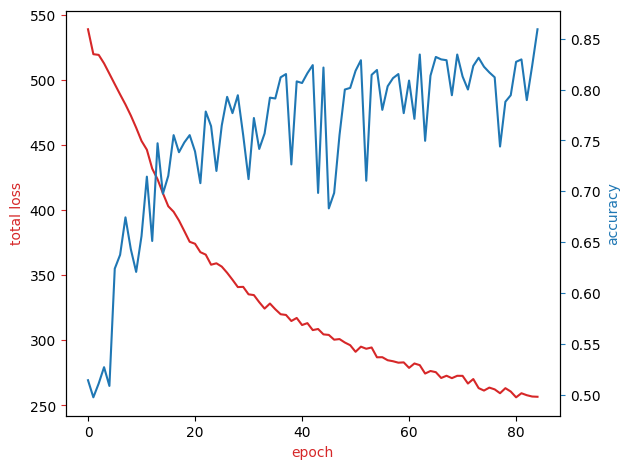

In [40]:
acc_urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/sybqacL5p1qeEO8d4xRZNg/model-IMDB%20dataset%20small2-acc')
loss_urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/eOt6woGoaOB565T0RLH5WA/model-IMDB%20dataset%20small2-loss')
acc_epoch = pickle.load(acc_urlopened)
cum_loss_list = pickle.load(loss_urlopened)
plot(cum_loss_list,acc_epoch)

The following code loads your pretrained model and evaluates its performance on the test set. This can take approximately 4 minutes to run.


In [41]:
urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/q66IH6a7lglkZ4haM6hB1w/model-IMDB%20dataset%20small2.pth')
model_ = Net(vocab_size=vocab_size, num_class=2).to(device)
model_.load_state_dict(torch.load(io.BytesIO(urlopened.read()), map_location=device))
evaluate(test_dataloader, model_)

100%|██████████| 782/782 [01:02<00:00, 12.48it/s]


0.82996

As you can see, the pretrained model achieved an accuracy of approximately 83% on the test data.


### Fine-tune a model pretrained on the AG News dataset

Rather than training a model on the IMDB dataset as you did earlier, you have the option to fine-tune a model that has been pretrained on the AG News dataset, which is a collection of news articles. The goal of the AG News dataset is to categorize news articles into one of four categories: Sports, Business, Sci/tech, or World. You’ll start training a model from scratch on the AG News dataset. To save time, you can do this in just one cell. Also, for the sake of efficiency, train for only 2 epochs on a smaller dataset to demonstrate what the training process looks like. Note that this can take approximately 3 minutes to run.


In [42]:
train_iter_ag_news = AG_NEWS(split="train")

num_class_ag_news = len(set([label for (label, text) in train_iter_ag_news ]))
num_class_ag_news

# Split the dataset into training and testing iterators.
train_iter_ag_news, test_iter_ag_news = AG_NEWS()

# Convert the training and testing iterators to map-style datasets.
train_dataset_ag_news = to_map_style_dataset(train_iter_ag_news)
test_dataset_ag_news = to_map_style_dataset(test_iter_ag_news)

# Determine the number of samples to be used for training and validation (5% for validation).
num_train_ag_news = int(len(train_dataset_ag_news) * 0.95)

# Randomly split the training dataset into training and validation datasets using `random_split`.
# The training dataset will contain 95% of the samples, and the validation dataset will contain the remaining 5%.
split_train_ag_news_, split_valid_ag_news_ = random_split(train_dataset_ag_news, [num_train_ag_news, len(train_dataset_ag_news) - num_train_ag_news])

# Make the training set smaller to allow it to run fast as an example.
# IF YOU WANT TO TRAIN ON THE AG_NEWS DATASET, COMMENT OUT THE 2 LINEs BELOW.
# HOWEVER, NOTE THAT TRAINING WILL TAKE A LONG TIME
num_train_ag_news = int(len(train_dataset_ag_news) * 0.05)
split_train_ag_news_, _ = random_split(split_train_ag_news_, [num_train_ag_news, len(split_train_ag_news_) - num_train_ag_news])


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

def label_pipeline(x):
   return int(x) - 1

from torch.nn.utils.rnn import pad_sequence

def collate_batch_ag_news(batch):
    label_list, text_list = [], []
    for _label, _text in batch:
        label_list.append(label_pipeline(_label))
        text_list.append(torch.tensor(text_pipeline(_text), dtype=torch.int64))


    label_list = torch.tensor(label_list, dtype=torch.int64)
    text_list = pad_sequence(text_list, batch_first=True)


    return label_list.to(device), text_list.to(device)

BATCH_SIZE = 32

train_dataloader_ag_news = DataLoader(
    split_train_ag_news_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch_ag_news
)
valid_dataloader_ag_news = DataLoader(
    split_valid_ag_news_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch_ag_news
)
test_dataloader_ag_news = DataLoader(
    test_dataset_ag_news, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch_ag_news
)


model_ag_news = Net(num_class=4,vocab_size=vocab_size).to(device)
model_ag_news.to(device)


LR=1
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_ag_news.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
save_dir = ""
file_name = "model_AG News small1.pth"
train_model(model=model_ag_news, optimizer=optimizer, criterion=criterion, train_dataloader=train_dataloader_ag_news, valid_dataloader=valid_dataloader_ag_news,  epochs=2, save_dir=save_dir, file_name=file_name)


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1/2 - Loss: 269.39922177791595


 50%|█████     | 1/2 [00:06<00:06,  6.83s/it]

0.24266666666666667
Epoch 2/2 - Loss: 263.42649245262146


100%|██████████| 2/2 [00:13<00:00,  6.70s/it]

0.29133333333333333
Training time: 13.404196739196777


Naturally, the model you trained earlier with just 2 epochs and a reduced dataset would not be used. Instead, you’ll use a model that has been pretrained using the same method but on the full AG News dataset and with 100 epochs.

The following code plots the cost and validation data accuracy for each epoch of the pretrained model up to and including the epoch that yielded the highest accuracy. As you can see, the pretrained model achieved a very high accuracy of over 90% on the AG News validation set.


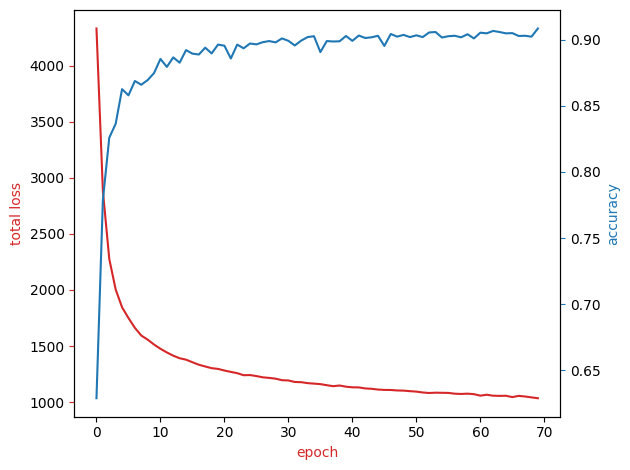

In [43]:
acc_urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/bQk8mJu3Uct3I4JEsEtRnw/model-AG%20News%20small1-acc')
loss_urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/KNQkqJWWwY_XfbFBRFhZNA/model-AG%20News%20small1-loss')
acc_epoch = pickle.load(acc_urlopened)
cum_loss_list = pickle.load(loss_urlopened)
plot(cum_loss_list,acc_epoch)

The following code loads the pretrained model and evaluates its performance on the AG News test set.


In [44]:
urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/9c3Dh2O_jsYBShBuchUNlg/model-AG%20News%20small1.pth')
model_ag_news_ = Net(vocab_size=vocab_size, num_class=4).to(device)
model_ag_news_.load_state_dict(torch.load(io.BytesIO(urlopened.read()), map_location=device))
evaluate(test_dataloader_ag_news, model_ag_news_)

100%|██████████| 238/238 [00:01<00:00, 148.27it/s]


0.9047368421052632

As you can see, the pretrained model worked extremely well on the AG News dataset. However, can this model be fine-tuned to perform well on the IMDB dataset as well? Let's find out! You can start off by loading the pretrained AG News model.


In [45]:
urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/9c3Dh2O_jsYBShBuchUNlg/model-AG%20News%20small1.pth')
model_fine1 = Net(vocab_size=vocab_size, num_class=4).to(device)
model_fine1.load_state_dict(torch.load(io.BytesIO(urlopened.read()), map_location=device))


<All keys matched successfully>

The IMDB dataset is a binary classification task with only two classes (positive and negative reviews). Therefore, the output layer of the AG NEWS model should be adjusted to have just two output neurons to reflect the binary nature of the IMDB dataset. This adjustment is essential for the model to accurately learn and predict the sentiment of movie reviews in the IMDB dataset.


In [46]:
model_fine1.classifier
in_features = model_fine1.classifier.in_features
print("Original final layer:", model_fine1.classifier)
print("Input dimention  final layer:", in_features)

Original final layer: Linear(in_features=100, out_features=4, bias=True)
Input dimention  final layer: 100


You can change the final layer into a two-class problem.


In [47]:
model_fine1.classifier = nn.Linear(in_features, 2)
model_fine1.to(device)

Net(
  (emb): Embedding(400000, 100)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=100, out_features=100, bias=True)
        )
        (linear1): Linear(in_features=100, out_features=128, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=128, out_features=100, bias=True)
        (norm1): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (classifier): Linear(in_features=100, out_features=2, bias=True)
)

The following code shows the layers that are frozen (`requires_grad == False`) and unfrozen (`requires_grad == True`) in the model. The unfrozen layers will have their weights updated during fine-tuning.


In [48]:
for name, param in model_fine1.named_parameters():
    print(f"{name} requires_grad: {param.requires_grad}")

emb.weight requires_grad: False
transformer_encoder.layers.0.self_attn.in_proj_weight requires_grad: True
transformer_encoder.layers.0.self_attn.in_proj_bias requires_grad: True
transformer_encoder.layers.0.self_attn.out_proj.weight requires_grad: True
transformer_encoder.layers.0.self_attn.out_proj.bias requires_grad: True
transformer_encoder.layers.0.linear1.weight requires_grad: True
transformer_encoder.layers.0.linear1.bias requires_grad: True
transformer_encoder.layers.0.linear2.weight requires_grad: True
transformer_encoder.layers.0.linear2.bias requires_grad: True
transformer_encoder.layers.0.norm1.weight requires_grad: True
transformer_encoder.layers.0.norm1.bias requires_grad: True
transformer_encoder.layers.0.norm2.weight requires_grad: True
transformer_encoder.layers.0.norm2.bias requires_grad: True
transformer_encoder.layers.1.self_attn.in_proj_weight requires_grad: True
transformer_encoder.layers.1.self_attn.in_proj_bias requires_grad: True
transformer_encoder.layers.1.sel

The following block simulates fine-tuning on the shortened training set for just 2 epochs. This code should take approximately 2 minutes to run.


In [49]:
LR=1
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_fine1.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
save_dir = ""
file_name = "model_fine1.pth"
train_model(model=model_fine1, optimizer=optimizer, criterion=criterion, train_dataloader=train_dataloader, valid_dataloader=valid_dataloader,  epochs=2,  save_dir=save_dir ,file_name=file_name )

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1/2 - Loss: 27.979596972465515


 50%|█████     | 1/2 [00:15<00:15, 15.65s/it]

0.4968
Epoch 2/2 - Loss: 27.760418355464935


100%|██████████| 2/2 [00:30<00:00, 15.48s/it]

Training time: 30.973979234695435


Of course, you will not use the model you just fine-tuned on 2 epochs and a shortened dataset. Instead, show the progress of the fine-tuning of the full IMDB training set for 100 epochs.


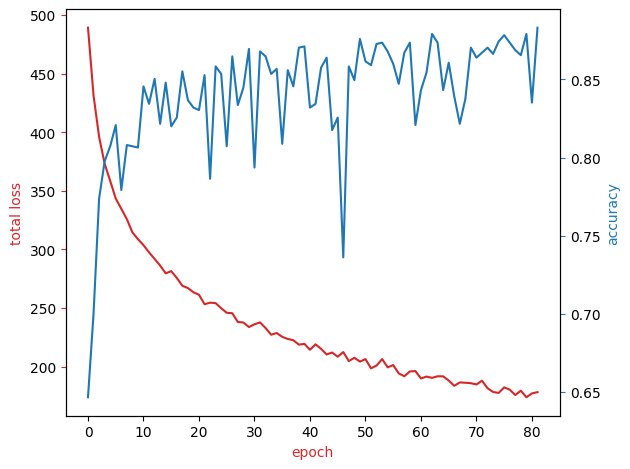

In [50]:
acc_urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/3LEJw8BRgJJFGqlLxaETxA/model-fine1-acc')
loss_urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/-CT1h97vjv0TolY82Nw29g/model-fine1-loss')
acc_epoch = pickle.load(acc_urlopened)
cum_loss_list = pickle.load(loss_urlopened)
plot(cum_loss_list,acc_epoch)

The following line loads the prefine-tuned model and evaluates its performance on the IMDB test set.


In [51]:
urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/e0WOHKh5dnrbC2lGhpsMMw/model-fine1.pth')
model_fine1_ = Net(vocab_size=vocab_size, num_class=2).to(device)
model_fine1_.load_state_dict(torch.load(io.BytesIO(urlopened.read()), map_location=device))
evaluate(test_dataloader, model_fine1_)

100%|██████████| 782/782 [01:04<00:00, 12.11it/s]


0.86036

This model demonstrated notable improvement, exhibiting a remarkable achievement with an accuracy of 86% on the test data. This is higher than the 83% achieved by the model trained from scratch on the IMDB dataset. Although the training process was time-intensive (in fact, the fine-tuning was as time-intensive as training the model from scratch), the enhanced performance underscores the fine-tuned model's effectiveness and superiority over the model trained from scratch. A substantial portion of the computational effort was devoted to updating the transformer layers. To expedite the training process, one viable strategy is to focus on training the final layer only, which can significantly reduce the computational load but might compromise the model's accuracy.


### Fine-tune the final layer only

Fine-tuning the final output layer of a neural network is similar to fine-tuning the whole model. You can begin by loading the pretrained model you would like to fine-tune. In this case, it is the same model pretrained on the AG News dataset.


In [52]:
urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/9c3Dh2O_jsYBShBuchUNlg/model-AG%20News%20small1.pth')
model_fine2 = Net(vocab_size=vocab_size, num_class=4).to(device)
model_fine2.load_state_dict(torch.load(io.BytesIO(urlopened.read()), map_location=device))

<All keys matched successfully>

Now here is the key difference: You iterate through all of the parameters in the `model_fine2` model and set the `requires_grad` attribute of each parameter to `False`. This effectively freezes all of the layers in the model, meaning that their weights are be updated during training.


In [53]:
# Freeze all layers in the model
for param in model_fine2.parameters():
    param.requires_grad = False

Replace the final layer to reflect the fact that you are solving a two-class problem. Note that the new layer will be unfrozen.


In [54]:
dim=model_fine2.classifier.in_features

In [55]:
model_fine2.classifier = nn.Linear(dim, 2)

In [56]:
model_fine2.to(device)


Net(
  (emb): Embedding(400000, 100)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=100, out_features=100, bias=True)
        )
        (linear1): Linear(in_features=100, out_features=128, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=128, out_features=100, bias=True)
        (norm1): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (classifier): Linear(in_features=100, out_features=2, bias=True)
)

To simulate training the model, simply execute the following cell, which trains on the shorted IMDB train set for just 2 epochs. The following code should take a shorter amount of time to train than the full fine-tuning conducted previously because only the final layer is unfrozen.


In [57]:
LR=1
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_fine2.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
save_dir = ""
file_name = "model_fine2.pth"
train_model(model=model_fine2, optimizer=optimizer, criterion=criterion, train_dataloader=train_dataloader, valid_dataloader=valid_dataloader,  epochs=2,  save_dir=save_dir ,file_name=file_name )


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1/2 - Loss: 27.912385046482086


 50%|█████     | 1/2 [00:09<00:09,  9.88s/it]

0.5032
Epoch 2/2 - Loss: 27.938794136047363


100%|██████████| 2/2 [00:20<00:00, 10.03s/it]

0.5304
Training time: 20.05196499824524


Once again, you will not use the model that you just fine-tuned, but instead inspect the fine-tuning process of a model fine-tuned on the full IMDB training set for 100 epochs.


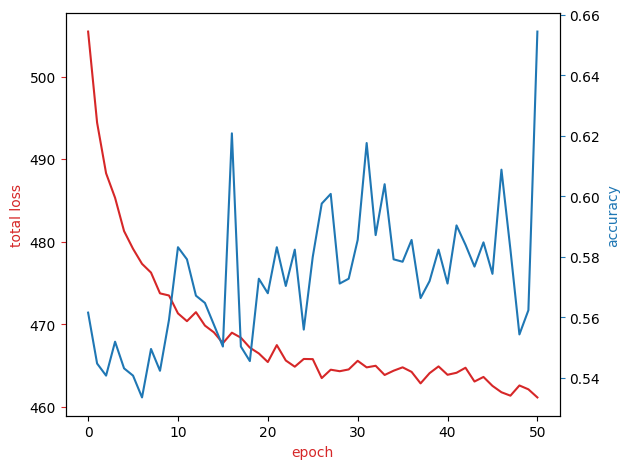

In [58]:
acc_urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/UdR3ApQnxSeV2mrA0CbiLg/model-fine2-acc')
loss_urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/rWGDIF-uL2dEngWcIo9teQ/model-fine2-loss')
acc_epoch = pickle.load(acc_urlopened)
cum_loss_list = pickle.load(loss_urlopened)
plot(cum_loss_list,acc_epoch)

The following line loads the model fine-tuned for 100 epochs on the full IMDB train set and evaluates its performance on the IMDB test set.


In [59]:
urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/B-1H6lpDg-A0zRwpB6Ek2g/model-fine2.pth')
model_fine2_ = Net(vocab_size=vocab_size, num_class=2).to(device)
model_fine2_.load_state_dict(torch.load(io.BytesIO(urlopened.read()), map_location=device))
evaluate(test_dataloader, model_fine2_)

100%|██████████| 782/782 [01:05<00:00, 11.87it/s]


0.63928

The previous code indicates that although fine-tuning the final layer takes a significantly smaller amount of time than fine-tuning the whole model, the performance of the model with just the last layer unfrozen is significantly worse (64% accuracy) than the fine-tuned model with all layers unfrozen (86% accuracy).


---
## Exercise: Unfreeze specific layers for fine-tuning

First, run the following code block to initialize a model.


In [60]:
model_finetune_some_layers = Net(num_class=4,vocab_size=vocab_size).to(device)

# Freeze all layers in the model
for param in model_finetune_some_layers.parameters():
    param.requires_grad = False

model_finetune_some_layers

Net(
  (emb): Embedding(400000, 100)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=100, out_features=100, bias=True)
        )
        (linear1): Linear(in_features=100, out_features=128, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=128, out_features=100, bias=True)
        (norm1): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (classifier): Linear(in_features=100, out_features=4, bias=True)
)

Now, replace the section labeled `### REPLACE THIS ###` in the following code block to unfreeze the following layers for fine-tuning:
- `linear2` for all `layers` in `transformer_encoder`
- The `classifier` layer, which you will convert into a layer that has three output classes


In [62]:
# Unfreeze the "linear2" layers:
for i in range(2):
    for param in model_finetune_some_layers.transformer_encoder.layers[i].linear2.parameters():
        param.requires_grad = True

# Replace the "classifier" layer. Note that this has the effect of unfreezing that layer:
model_finetune_some_layers.classifier  = nn.Linear(100, 3)

# Output all parameters indicating whether those parameters are unfrozen:
for name, param in model_finetune_some_layers.named_parameters():
    print(f"{name} requires_grad: {param.requires_grad}")

emb.weight requires_grad: False
transformer_encoder.layers.0.self_attn.in_proj_weight requires_grad: False
transformer_encoder.layers.0.self_attn.in_proj_bias requires_grad: False
transformer_encoder.layers.0.self_attn.out_proj.weight requires_grad: False
transformer_encoder.layers.0.self_attn.out_proj.bias requires_grad: False
transformer_encoder.layers.0.linear1.weight requires_grad: False
transformer_encoder.layers.0.linear1.bias requires_grad: False
transformer_encoder.layers.0.linear2.weight requires_grad: True
transformer_encoder.layers.0.linear2.bias requires_grad: True
transformer_encoder.layers.0.norm1.weight requires_grad: False
transformer_encoder.layers.0.norm1.bias requires_grad: False
transformer_encoder.layers.0.norm2.weight requires_grad: False
transformer_encoder.layers.0.norm2.bias requires_grad: False
transformer_encoder.layers.1.self_attn.in_proj_weight requires_grad: False
transformer_encoder.layers.1.self_attn.in_proj_bias requires_grad: False
transformer_encoder.

<details>
    <summary>Click here for the solution</summary>

```python
# Unfreeze the "linear2" layers:
for i in range(2):
    for param in model_finetune_some_layers.transformer_encoder.layers[i].linear2.parameters():
        param.requires_grad = True

# Replace the "classifier" layer. Note that this has the effect of unfreezing that layer:
model_finetune_some_layers.classifier  = nn.Linear(100, 3)

# Output all parameters indicating whether those parameters are unfrozen:
for name, param in model_finetune_some_layers.named_parameters():
    print(f"{name} requires_grad: {param.requires_grad}")
```

</details>


### Training Specific layer

In [63]:
LR=1
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_fine2.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
save_dir = ""
file_name = "model_fine2.pth"
train_model(model=model_finetune_some_layers, optimizer=optimizer, criterion=criterion, train_dataloader=train_dataloader, valid_dataloader=valid_dataloader,  epochs=2,  save_dir=save_dir ,file_name=file_name )


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1/2 - Loss: 63.741915822029114


 50%|█████     | 1/2 [00:12<00:12, 13.00s/it]

Epoch 2/2 - Loss: 63.92195403575897


100%|██████████| 2/2 [00:25<00:00, 12.86s/it]

Training time: 25.720240831375122


---


## Congratulations! You have completed the lab


## Authors


[Joseph Santarcangelo](https://author.skills.network/instructors/joseph_santarcangelo)

Joseph has a Ph.D. in Electrical Engineering, his research focused on using machine learning, signal processing, and computer vision to determine how videos impact human cognition. Joseph has been working for IBM since he completed his PhD.


[Wojciech "Victor" Fulmyk](https://www.linkedin.com/in/wfulmyk) 

Wojciech "Victor" Fulmyk is a Data Scientist at IBM, and a PhD Candidate in economics at the University of Calgary.


[Ashutosh Sagar](https://www.linkedin.com/in/ashutoshsagar/) is completing his MS in CS from Dalhousie University. He has previous experience working with Natural Language Processing and as a Data Scientist.


## References


[TEXT CLASSIFICATION WITH THE TORCHTEXT LIBRARY](https://pytorch.org/tutorials/beginner/text_sentiment_ngrams_tutorial.html)


© Copyright IBM Corporation. All rights reserved.
